*This notebook, `summary.ipynb`, contains analysis of the open-coding processes itself. It depends upon CSV files generated by `notebook-search.ipynb`.*

# Import data and modules

In [1]:
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import re
from lib.util import getCodes, displayMarkdown

%autosave 0

alt.renderers.enable('notebook')

Autosave disabled


RendererRegistry.enable('notebook')

## Import codes

The cell below recursively searches the `notebooks/` directory for files with a `.html.pdf` extension. These are PDF printouts of computational notebooks and scripts that I coded using the comments feature in [Adobe Acrobat DC](https://acrobat.adobe.com/ca/en/acrobat.html). This notebook needs to import all codes from the open coding process.

In [2]:
%%time
codes = getCodes()

CPU times: user 2min 42s, sys: 960 ms, total: 2min 43s
Wall time: 2min 46s


## Import metadata on analyzed notebooks

The cell below parses the works-cited section of the `README.md` document with regular expressions. A demo of this regular expression can be found on [regexr.com](https://regexr.com/4htcn). This section contains a citation for every notebook included in this analysis. Some of the URLs from the works cited list are cleaned so that the path matches the path in this repository under `notebooks/`.

In [3]:
regxp = r'\n([^\n\.\#]+)\.\s\((\d{4}),\s(\w+)\s(\d+)\)\.\s([^\.]+\.)\s\*([^\*]+)\*\.\sRetrieved from https:\/\/(?:[^\/]+\/){2}(.*)\n'
with open('README.md') as readme:
    content = readme.read()

citations = re.findall(regxp,content)
citations = pd.DataFrame(citations, columns=['journalist', 'year', 'month', 'date', 'article', 'organization', 'path'])

citations.replace(to_replace=r'data/tree/master/|data-projects/tree/master/|2016/05/|st-methods/tree/master/', 
                  value='', 
                  regex=True, 
                  inplace=True)

citations.head()

,journalist,year,month,date,article,organization,path
0,"Aldhous, Peter",2016,September,16,"""Shy Trumpers"" polling analysis.",BuzzFeed News,2016-09-shy-trumpers
1,"Arthur, Rob",2015,July,30,Buster Posey MVP.,FiveThirtyEight,buster-posey-mvp
2,"Bi, Frank",2016,Jan,13,Uber launch cities and date.,Vox,verge-uber-launch-dates
3,"Bradshaw, Paul",2019,April,6,Lack of electric car charging points 'putting ...,BBC,electric-car-charging-points
4,"Bradshaw, Paul",2019,March,8,Birmingham remains top destination for Londoners.,BBC,internal-migration-london


## Import repos and contributors

The file `notebook-search.ipynb` mines GitHub for repos containing data-journalism workflows and exports this data to `data/repos.csv` and `data/contributors.csv`.

In [4]:
# Get all repos
repos = pd.read_csv('data/repos.csv')

# Subset repos to only those that contained data analysis
keepers = repos[repos.is_keeper == True]

# Get contributors, which is really contributors to keeper notebooks
contributors = pd.read_csv('data/contributors.csv')

# Analysis Stats

In [5]:
byTheNumbers = citations.loc[:,['journalist', 'organization', 'article']].describe().loc['unique',:].to_frame('count')
byTheNumbers = byTheNumbers.append(pd.DataFrame({
        'count': [ codes.code.nunique(), 
                   repos.shape[0],
                   keepers.shape[0],
                   keepers.org.nunique(),
                 ],
    }, index=['codes', 'repos', 'relevant repos', 'total organizations']))

byTheNumbers

,count
journalist,30
organization,25
article,47
codes,150
repos,181
relevant repos,181
total organizations,38


# Establishing convergence
TK

## Notebook coding order

The works cited page of analyzed computational notebooks serves as a list of coded notebooks, but it doesn't preserve the order in which they were coded. The `reposIncluded` list has lists each repo in reverse chronological order.

In [6]:
pathsIncluded = [
    'california-buildings-in-severe-fire-hazard-zones',
    'swana-population-map',
    '1805-regionen im fokus des US-praesidenten',
    'school-choice',
    '201901-achievementgap',
    'general-election-2015-classification-tree',
    '201901-hospitalquality',
    'awb-notebook',
    'skatemusic',
    'new-york-schools-assessment',
    'lending-club',
    'auditData',
    '2019-ems-analysis',
    'federal_employees_trump_2017', 
    'infrastructure-jobs',
    'librarians',
    'midwife-led-units',
    'internal-migration-london',
    'electric-car-charging-points',
    'school-star-ratings-2018',
    'prison-admissions',
    'vox-central-line-infections',
    'verge-uber-launch-dates',
    'buster-posey-mvp',
    'work-from-home',
    'nyc-trips',
    'bob-ross',
    'bechdel',
    'employment-discrimination',
    '2015-11-refugees-in-the-united-states',
    'babyname_politics',
    'wikipedia-rankings',
    'Power_of_Irma',
    'Endangered-Species-Act-Louisiana',
    'california-h2a-visas-analysis',
    '2016-04-republican-donor-movements',
    'the-cube-root-law',
    '2016-09-shy-trumpers',
    '2018-05-31-crime-and-heat-analysis',
    '2016-11-bellwether-counties',
    'heat-index',
    '2018-voter-registration',
    'long-term-care-db',
    'census-hard-to-map-analysis',
    'california-crop-production-wages-analysis',
    'california-ccscore-analysis',
    '2019-04-democratic-candidate-codonors',
]

codingOrder = pd.DataFrame({'article': pathsIncluded[::-1] }).reset_index().rename(columns={'index': 'coding order'})

### Sanity check

Make sure that I've manually added all the repos to `reposIncluded` that are listed in `README.md`.

In [7]:
citMinusPath = set(citations.path.unique()).difference(set(pathsIncluded))
pathMinusCit = set(pathsIncluded).difference(set(citations.path.unique()))

if len(citMinusPath) > 0:
    displayMarkdown('In `citations` but not in `pathsIncluded`: {}'.format(', '.join(list(citMinusPath))))
else:
    displayMarkdown('All paths in `citations` are also in `pathsIncluded`\n')

if len(pathMinusCit) > 0:
    displayMarkdown('In `pathsIncluded` but not in `citations`: {}'.format(', '.join(list(pathMinusCit))))
else:
    displayMarkdown('All paths in `pathsIncluded` are also in `citations`\n')

All paths in `citations` are also in `pathsIncluded`


All paths in `pathsIncluded` are also in `citations`


## Visualizing code set growth

In order to visualize the cardinality of the code set per notebook coded, the `codes` data frame needs to be grouped by article.

In [8]:
codesByArticle = codes.groupby(['article']).code \
    .unique() \
    .to_frame('codes') \
    .reset_index() \
    .merge(codingOrder, on='article') \
    .sort_values('coding order') \
    .reset_index()

codesByArticle['cumulative count'] = 0

codeset = set()
for i, row in codesByArticle.iterrows():
    setDiff = set(row.codes).difference(codeset)
    codeset = codeset.union(setDiff)
    codesByArticle.loc[i, 'cumulative count'] = len(codeset)
    codesByArticle.loc[i, 'new codes'] = ', '.join(setDiff)

codesByArticle.head()

,index,article,codes,coding order,cumulative count,new codes
0,7,2019-04-democratic-candidate-codonors,"[use open government data, load, architect a s...",0,28,"change case, outer join tables, sort table, gr..."
1,20,california-ccscore-analysis,"[format table display, load, subset columns, c...",1,43,"calculate percentage difference, inspect table..."
2,21,california-crop-production-wages-analysis,"[use open government data, format table displa...",2,50,"answer a question, adjust for inflation, archi..."
3,23,census-hard-to-map-analysis,"[wrangle data for graphics, use open governmen...",3,52,"tolerate dirty data, slice column values"
4,33,long-term-care-db,"[count value frequency, calculate scaled ratio...",4,63,"drop erroneous rows, join with lookup table, e..."


Plot the size of the code set as more computational notebooks are analyzed.

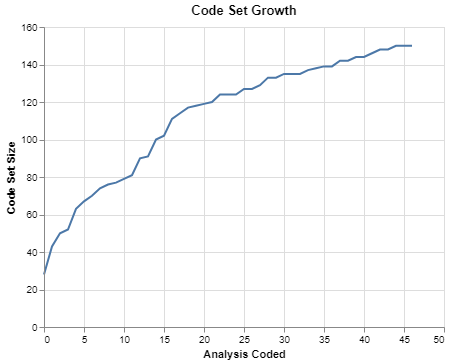

In [9]:
alt.Chart(data = codesByArticle, title = 'Code Set Growth') \
    .mark_line() \
    .encode(
        x = alt.X('coding order:Q', title="Analysis Coded"),
        y = alt.Y('cumulative count:Q', title="Code Set Size")
    )

For each notebook included in analysis list which codes were introduced to the code set. After 23 notebooks, some computational notebooks didn't add any new codes.

In [10]:
for i, row in codesByArticle.iterrows():
    displayMarkdown('{}. **{}**: {}'.format(i + 1, row.article, row['new codes']))

1. **2019-04-democratic-candidate-codonors**: change case, outer join tables, sort table, group by multiple columns, compare different groups along a common metric, peek at data, group by single column, export intermediate results, subset columns, self join table, union tables, load, create a semi-unique key, sum along dimension, strip whitespace, remove value characters, trim by contains value, repetitive code, count value frequency, canonicalize column names, use open government data, architect a subroutine, calculate ratio, calculate scaled ratio, drop duplicate rows based on prior knowledge, annotate workflow, gather table, count unique values in column

2. **california-ccscore-analysis**: calculate percentage difference, inspect table schema, calculate difference, split, compute, and merge, trim by date range, calculate mean, count number of rows, export results, calculate z-score, format table display, trim by quantitative threshold, create a crosstab, drop duplicate rows based on values, change column data type, visualize data

3. **california-crop-production-wages-analysis**: answer a question, adjust for inflation, architect repeating process, wrangle data for graphics, inner join tables, construct table manually, trim by geographic area

4. **census-hard-to-map-analysis**: tolerate dirty data, slice column values

5. **long-term-care-db**: drop erroneous rows, join with lookup table, encode table identification in row, construct pivot table, fix data errors manually, scrape web for data, use non-public, provided data, combine entities manually, aggregate the forest from the trees, refine table, fill in na values after an outer join

6. **2018-voter-registration**: pull tables out of pdf, create rolling window, show trend over time, calculate a statistic

7. **heat-index**: cartesian product, generate data computationally, compute index number

8. **2016-11-bellwether-counties**: spread table, get extreme values, remove incomplete data, use academic data

9. **2018-05-31-crime-and-heat-analysis**: extract property from datetime, combine seemingly disparate datasets

10. **2016-09-shy-trumpers**: use another news orgs data

11. **the-cube-root-law**: use public data, wtf

12. **2016-04-republican-donor-movements**: explore dynamic network flow, split column on delimiter

13. **california-h2a-visas-analysis**: cache results from external service, temporary joining column, replace na values, preserve existing values, create a unique key, create child table, perform entity resolution manually, geocode addresses, split and compute

14. **Endangered-Species-Act-Louisiana**: transform vector

15. **Power_of_Irma**: fix incorrect calculation, outlier detection, use previously cleaned data, set data confidence threshold, change date format, toggle step on and off, value replacement, interpret statistical/ml model, use data from colleague

16. **wikipedia-rankings**: explain variance, collect raw data

17. **babyname_politics**: round floating point, concatenate columns into key, assign ranks, check results of previous operation, get unique values, resort after merge, break ties, data loss from aggregation, join aggregate

18. **2015-11-refugees-in-the-united-states**: test for equality, make an incorrect conclusion, designate column as primary key

19. **employment-discrimination**: align table columns for consolidation, concatenate files together, merge tables to create pivot table

20. **bechdel**: calculate median

21. **bob-ross**: whiten matrix

22. **nyc-trips**: full join tables

23. **work-from-home**: create flag, copy table schema, translate entity names manually, data too large for repo

24. **buster-posey-mvp**: 

25. **verge-uber-launch-dates**: 

26. **vox-central-line-infections**: report rows with column number discrepancies, correct bad formatting, sort table rows

27. **prison-admissions**: 

28. **school-star-ratings-2018**: pad column values, display rows with missing values

29. **electric-car-charging-points**: create edge, define edge weights, find nearest neighbours in the network, encode redundant information

30. **internal-migration-london**: 

31. **midwife-led-units**: test different computations for equality, freedom of information data

32. **librarians**: 

33. **infrastructure-jobs**: 

34. **federal_employees_trump_2017**: rollup, resolve to arbitrary entity name among choices

35. **2019-ems-analysis**: combine data and geography

36. **auditData**: combine columns

37. **lending-club**: 

38. **new-york-schools-assessment**: create lookup table, combine drifting datasets, backfill missing data

39. **skatemusic**: 

40. **awb-notebook**: silently dropping values after groupby, resolve by substring

41. **201901-hospitalquality**: 

42. **general-election-2015-classification-tree**: check for nas, wrangle data for model

43. **201901-achievementgap**: query database, bin values

44. **school-choice**: 

45. **1805-regionen im fokus des US-praesidenten**: concat parallel tables, compute an inter-table column

46. **swana-population-map**: 

47. **california-buildings-in-severe-fire-hazard-zones**: 

# Analysis Coverage

In order to prevent this code set from being biased by one individual or organization's data wrangling behavior, we deliberately sought out notebooks from a variety of news organizations and data journalists. This analysis comes from, but is not limited to, news organizations that constitute "major players" in data journalism. 

In [11]:
def displayCoverage(df, title, metric, xlab):
    """"""
    rank = '{}_rank'.format(metric)
    count = '{}_count'.format(metric)    
    
    bars = alt.Chart(data = df.sort_values(rank).head(50), title = title) \
        .mark_bar() \
        .encode(
            x = alt.X('{}:Q'.format(count), axis = alt.Axis(title = xlab)),
            y = alt.Y('name:N',
                  sort = alt.EncodingSortField(field = count, order = 'descending'),
                  axis = alt.Axis(title = 'News Organization')
            ),
            color = alt.Color('is_included:N', title = 'Included in analysis?')
        )

    display(bars.properties(height=500, width=500))

    displayMarkdown("""
        This analysis includes the top {} organizations by {} count.
    """.format(df[df.is_included == False][rank].min() - 1, metric))

## Including the top-n news organizations

We ranked these organizations by two metrics: those with the most separate repositories and the most Git commits among all repos.

In [12]:
orgs = repos[repos.is_keeper == True] \
    .groupby('org') \
    .agg({
        'url': 'nunique',
        'commits': 'sum'
    }) \
    .reset_index() \
    .rename(columns={
        'org': 'name', 
        'url': 'repo_count',
        'commits': 'commit_count'
    })

# Assign ranks to each organization per repo count and commit count
def rank(df, sort_col, rank_col):
    df.sort_values(sort_col, ascending=False, inplace=True)
    df[rank_col] = df.reset_index().index + 1

rank(orgs, 'repo_count', 'repo_rank')
rank(orgs, 'commit_count', 'commit_rank')

# Find which organizations have been included in analysis
includedOrgs = list(citations.organization.unique())
orgs['is_included'] = False
orgs.loc[orgs.name.isin(includedOrgs), 'is_included'] = True

# Ok, so what did I do?
orgs.head()

,name,repo_count,commit_count,repo_rank,commit_rank,is_included
10,FiveThirtyEight,1,907,36,1,True
0,Austin American-Statesman,11,277,3,2,True
3,Baltimore Sun,12,277,2,3,True
4,BuzzFeed News,77,242,1,4,True
34,TrendCT,4,164,10,5,True


### Top by number of repos

Most news organizations, including *BuzzFeed News*, *Los Angeles Times*, and the *Austin American-Statesman*, create one repo per analysis work flow.


        This analysis includes the top 19 organizations by repo count.
    

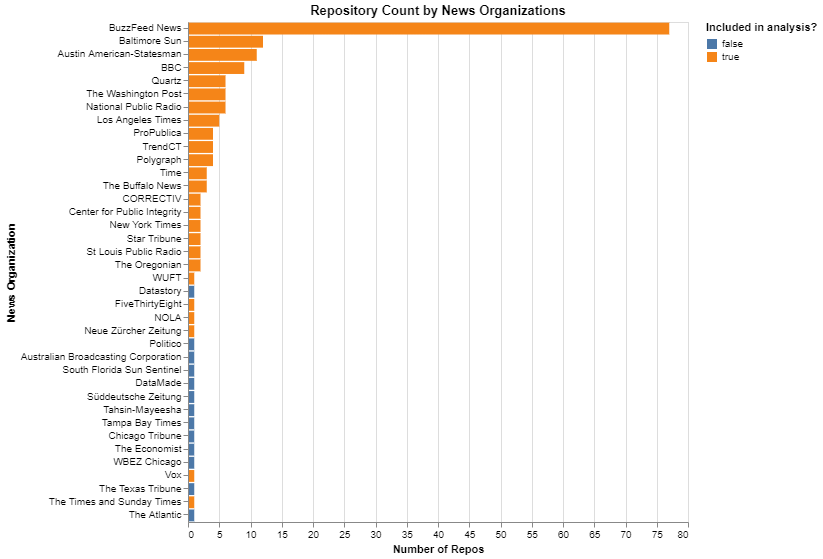

In [13]:
displayCoverage(orgs,
                title = 'Repository Count by News Organizations', 
                metric = 'repo',
                xlab = 'Number of Repos')

### Top by number of commits

However, one limitation of ranking news organizations by repo count is that some organizations, such as *FiveThirtyEight* keep computational notebooks for multiple data journalism articles in one repo.

A *commit* in Git can be thought of as a unit of change for a repo. Thus the more a repo has changed overtime, the more commits. If a news organization is only using one repo for all their data journalism work, then it should have lots of commits.


        This analysis includes the top 18 organizations by commit count.
    

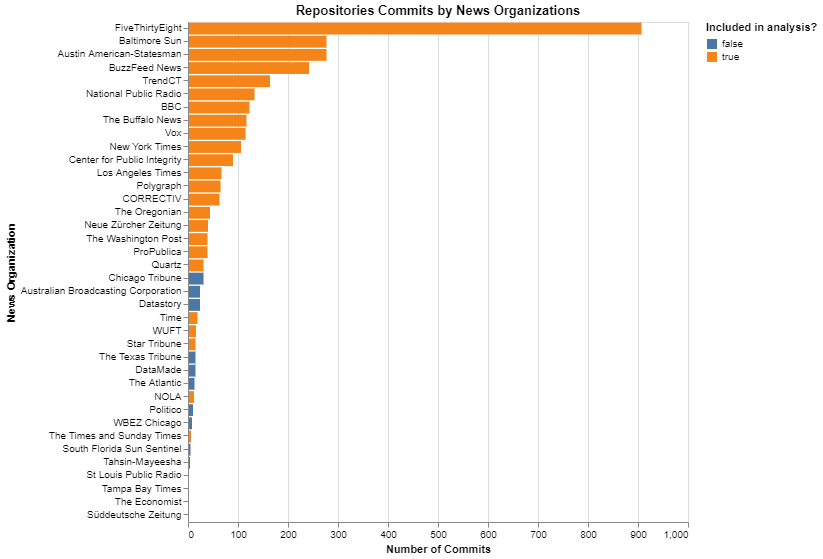

In [14]:
displayCoverage(orgs,
                title = 'Repositories Commits by News Organizations', 
                metric = 'commit',
                xlab = 'Number of Commits')

### Which organizations were included?

In [15]:
included_count = sum(orgs.is_included)
total_orgs = len(orgs.name.unique())

displayMarkdown("""
This analysis includes {included_count} news organizations out of {total} that had computational notebooks deemed relevant to this analysis ({percent}%).
""".format(**{
    'included_count': included_count,
    'total': total_orgs,
    'percent': round((included_count / total_orgs) * 100, 2),
}))

displayMarkdown("""
| Organization | Is included? |
| ------------ | ------------ |
{rows}
""".format(**{
    'rows': '\n '.join([ '| {} | {} |'.format(row[0], '✔️' if row[5] else '❌') for i, row in orgs.sort_values('name').iterrows() ])
}))


This analysis includes 25 news organizations out of 38 that had computational notebooks deemed relevant to this analysis (65.79%).



| Organization | Is included? |
| ------------ | ------------ |
| Austin American-Statesman | ✔️ |
 | Australian Broadcasting Corporation | ❌ |
 | BBC | ✔️ |
 | Baltimore Sun | ✔️ |
 | BuzzFeed News | ✔️ |
 | CORRECTIV | ✔️ |
 | Center for Public Integrity | ✔️ |
 | Chicago Tribune | ❌ |
 | DataMade | ❌ |
 | Datastory | ❌ |
 | FiveThirtyEight | ✔️ |
 | Los Angeles Times | ✔️ |
 | NOLA | ✔️ |
 | National Public Radio | ✔️ |
 | Neue Zürcher Zeitung | ✔️ |
 | New York Times | ✔️ |
 | Politico | ❌ |
 | Polygraph | ✔️ |
 | ProPublica | ✔️ |
 | Quartz | ✔️ |
 | South Florida Sun Sentinel | ❌ |
 | St Louis Public Radio | ✔️ |
 | Star Tribune | ✔️ |
 | Süddeutsche Zeitung | ❌ |
 | Tahsin-Mayeesha | ❌ |
 | Tampa Bay Times | ❌ |
 | The Atlantic | ❌ |
 | The Buffalo News | ✔️ |
 | The Economist | ❌ |
 | The Oregonian | ✔️ |
 | The Texas Tribune | ❌ |
 | The Times and Sunday Times | ✔️ |
 | The Washington Post | ✔️ |
 | Time | ✔️ |
 | TrendCT | ✔️ |
 | Vox | ✔️ |
 | WBEZ Chicago | ❌ |
 | WUFT | ✔️ |


## Including the top-n data journalists

The first step is to split (a.k.a explode) rows in the `citations` data frame that represent collaborative data journalism projects done by multiple journalists into separate rows. I've separated multiple authors in the citations with semicolons.

In [16]:
citations[citations.journalist.str.contains(';')]

,journalist,year,month,date,article,organization,path
20,"Keller, Josh; Pearce, Adam",2016,September,7,US State prison admissions by county.,New York Times,prison-admissions
24,"Menezes, Ryan; Stevens, Matt; Welsh, Ben",2016,October,31,"California ""Conservation-Consumption Score"" an...",Los Angeles Times,california-ccscore-analysis


In [17]:
citationsUnpacked = pd.DataFrame(list(citations.journalist.apply(lambda name: name.split(';'))),
            index=citations.path).stack().to_frame().reset_index([0, 'path']) \
    .rename(columns={0: 'journalist'})

citationJournalists = pd.merge(citationsUnpacked, citations.drop(['journalist'], axis=1), on='path', how='left')
citationJournalists['name'] = citationJournalists.journalist.apply(lambda name: "{} {}".format(*name.split(', ')[::-1]))
citationJournalists['is_cited'] = True
citationJournalists = citationJournalists[['name', 'is_cited']].drop_duplicates()
citationJournalists.head()

,name,is_cited
0,Peter Aldhous,True
1,Rob Arthur,True
2,Frank Bi,True
3,Paul Bradshaw,True
6,Stefano Ceccon,True


Modify the `citations` data frame so that it has a primary key to join the `contributors` data frame. The `journalist` column in `citations` is formatted as "given name, surname", so I'll swap those around.

From the `contributors` data frame, we can get a sense of the "top" data journalists based on how many commits they've made and the number of followers of their GitHub user account.

In [18]:
# Fun fact, this is an example of aggregate join
dataJournalists = pd.merge(
    contributors[['login', 'name']],
    contributors.groupby('login').agg({'followers': max, 'commits': sum }).reset_index(),
    on='login') \
    .drop_duplicates()

createPk = lambda df: df.name.str.lower().str.replace(r'\s', '')

dataJournalists['pk'] = createPk(dataJournalists)
citationJournalists['pk'] = createPk(citationJournalists)

# Combine to get a data frame of journalists included and not included in analysis
dataJournalists = pd.merge(dataJournalists, citationJournalists, how='left', on='pk') \
    .rename(columns={
        'is_cited': 'is_included',
        'followers': 'follower_count',
        'commits': 'commit_count',
        'name_x': 'name'
    }) \
    .drop(['name_y', 'pk'], axis=1)

dataJournalists.is_included.fillna(False, inplace=True)

# # Rank data journalists by followers and commits
rank(dataJournalists, 'follower_count', 'follower_rank')
rank(dataJournalists, 'commit_count', 'commit_rank')

# # Remove NAs
dataJournalists.dropna(inplace=True)

dataJournalists.head()

,login,name,follower_count,commit_count,is_included,follower_rank,commit_rank
78,dmil,Dhrumil Mehta,266,419,False,17,1
23,andrewbtran,Andrew Tran,99,159,True,31,2
124,carlmjohnson,Carl Johnson,43,144,False,62,3
10,jsvine,Jeremy Singer-Vine,562,126,True,5,4
116,lexieheinle,Lexie Heinle,10,114,True,102,5


### Sanity check

Did we loose any journalists from the citations list when we merged it with the list of data journalists?

In [19]:
display(set(citationJournalists.name).difference(set(dataJournalists.name)))

{'Adam  Pearce',
 'Ben  Welsh',
 'Matt  Stevens',
 'Rob Arthur',
 'Sahil Chinoy',
 'Soo Oh',
 'Stefano Ceccon',
 'Walter Hickey'}

Journalists who worked collaboratively and only one of them committed code.
* Matt Stevens
* Adam Pearce

Journalists who did Observable notebooks
* Sahil Chinoy

Journalists who did not commit their own code. Lots of FiveThirtyEight code appears to be committed by someone else.
* Rob Arthur
* Stefano Ceccon
* Walt Hickey

### Top data journalists by commits


        This analysis includes the top 0 organizations by commit count.
    

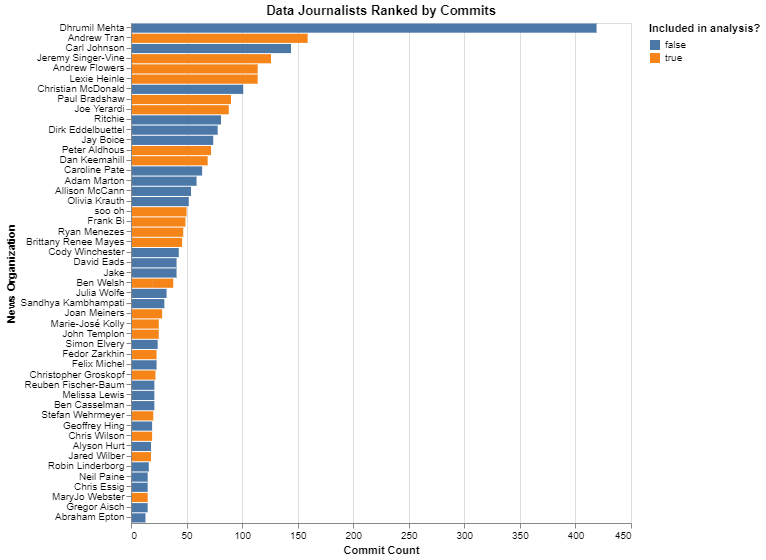

In [20]:
displayCoverage(
    df = dataJournalists,
    title = 'Data Journalists Ranked by Commits',
    metric = 'commit',
    xlab = 'Commit Count'
)

### Top data journalists by followers


        This analysis includes the top 0 organizations by follower count.
    

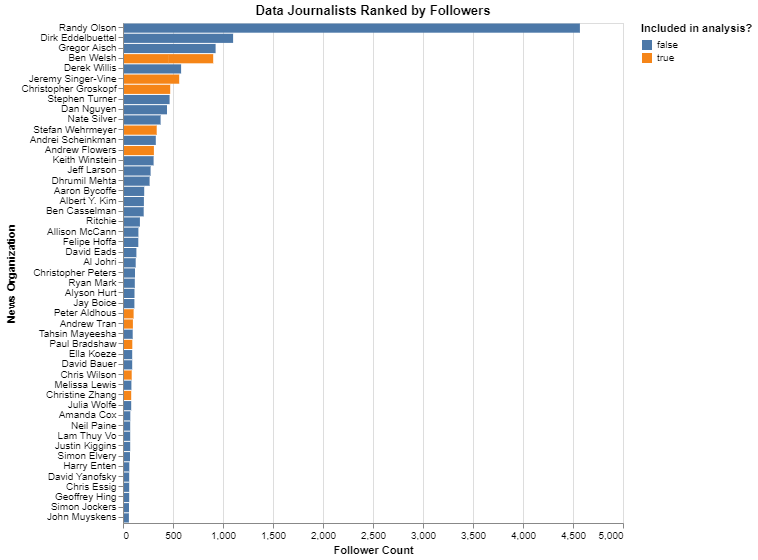

In [21]:
displayCoverage(
    df = dataJournalists,
    title = 'Data Journalists Ranked by Followers',
    metric = 'follower',
    xlab = 'Follower Count'
)